# Motion Models

Motion models are the fundamental concepts behind mobile robotics. They are used in various applications as tracking, motion prediction and control.|

We will focus on the most simple models: the constant velocity and the odometry motion model.



The idea behind a motion model is to "simplify" a complex kinematic motion that is subject to the control systems, the surface characteristics etc. which are either not known or too complex for certain applications.

In order to see the models in action, we will show their applications (interpolation and extrapolation).

Note: this notebook solely focuses on mobile (wheeled) Robotics; where we apply models on 2-dimensional planes (we are using $x$ and $y$ coordinates and omitting $z$) implying a `2-d location`. Adding the orientation $\theta$, we receive a `2-d pose`.


## Constant Velocity Model

Probably the most simple motion model. It defines that given a set of positions $x_i$ and $y_i$ at step $i$ along with their velocities $vx_i$, $vy_i$, the resulting positions at step $i+1$ are

$$
x_{i+1} =  x_{i} + \Delta t \cdot vx_{i}
$$
$$
y_{i+1} =  y_{i} + \Delta t \cdot vy_{i}
$$

=> it basically assumes that the velocity will not change. Although this model of a kinematic motion is very simple and definitely not very accurate, it does the job for many applications. Especially for very short motion prediction horizons (refer below).

### Motion Extrapolation (aka. Prediction) with Constant Velocity

### Intro

Using the above equations we can extrapolate or `predict` motions of objects. All we need is the current position. The velocity we can derive from two observations of the position. Hence,

$$
vx = \frac{x_i - x_{i-1}}{\Delta t}
$$

$$
vy = \frac{y_i - y_{i-1}}{\Delta t}
$$

with $\Delta t$ representing the difference in time between two observations.



Let's consider a simple example: we have a position $p_0 = \begin{pmatrix} 2 \\ 3\end{pmatrix}$ at timestep $t = 0$ and a position $p_1 = \begin{pmatrix} 5 \\ 6\end{pmatrix}$ at timestep $t = 1$.

Then the resulting velocities are $vx = 3$ and $vy = 3$ and we can extrapolate the motion onto a timestemp $t=2$ using the equations above. Yielding

$$
p_2 = p_1 \cdot \Delta t \cdot \begin{pmatrix} vx \\ vy\end{pmatrix} = \begin{pmatrix} x_2 \\ v_2 \end{pmatrix} \cdot \begin{pmatrix} vx \\ vy\end{pmatrix} = \begin{pmatrix} 5 \\ 6\end{pmatrix} \cdot 1 \cdot \begin{pmatrix} 3 \\ 3\end{pmatrix} = \begin{pmatrix} 8 \\ 8\end{pmatrix}
$$

Visualizing this example shows why this is also called a *linear motion model* => we can draw a line from the first to the last point.

This model will obviously not yield accurate predictions on longer horizons but it does very well on small values for $\Delta t$.

Text(7.5, 8.7, 'predicted')

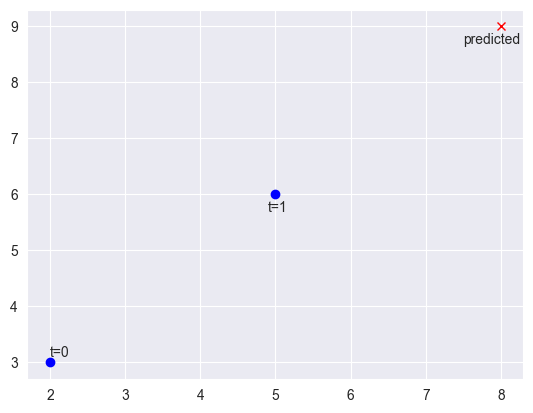

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

plt.plot(2,3, "bo")
plt.text(2, 3.1, s="t=0")
plt.plot(5,6, "bo")
plt.text(4.9, 5.7, s="t=1")
plt.plot(8, 9, "rx")
plt.text(7.5, 8.7, s="predicted")

### Adding Uncertainty

When predicting positions of objects, we  need to consider uncertainties resulting from:

1. the measurement (no sensor is 100% accurate and hence, no measured position is accurate) and
2. the prediction itself.

In general, we express uncertainties with variances of probability distibutions. Most often from the Gaussian distribution that is defined as

$$
\mathcal{N}(\mu,\,\sigma^{2})
$$ 
with $\mu$ representing the mean and $\sigma^{2}$ the variance.
With this additional information, we are now able to propagate our belief within our prediction. Let's give it a try with real data.

### Motion Prediction with Odometry Data

We will use the odometry data created in the `data_generation` notebook, that represents the ego-vehicle poses over time with accurate odometry / a differential GPS that pracitually enables us to interpret the odometry data as the "ground truth" for the upcoming tasks.

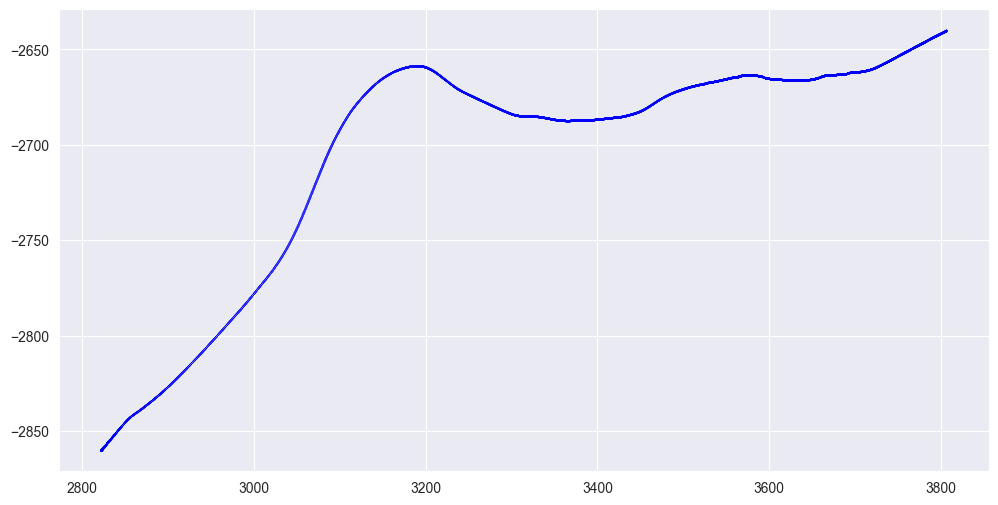

In [4]:
import pandas as pd
odometry_data = pd.read_csv("data/odometry_data.csv")
plt.figure(figsize=(12,6))
plt.plot(odometry_data.x_seq, odometry_data.y_seq, "bo", markersize=.1)

The plot above shows the observed positions in `x` and `y` direction of the ego-vehicle. It only shows the 2-d path without the temporal dimension (hence, not a trajectory).

We will use a few measurements for the prediction of the motion at specific timesteps and compare our predictions with the observations at the same timesteps.

For the observations, we will define a variance of $0.0005$ (m) (the measurements are of high quality, so we can trust them), for the prediction in $x$ direction a variance of $0.005$ (m) and for the prediction in $y$ direction a variance of  $0.01$ (m) per $\Delta t$. 

Why the different variances for $x$ and $y$? Depending on the types of sensors used, we have differences in accuracies. For our linear prediction, we would expect the $x$ direction to be more accurate than the $y$ direction in case the object is moving on a straight line along the $x$ axis simply because we do not consider the orientation in our motion model => this implies less accurate predictions for the $y$ direction.

$$
\mathcal{N_{observation}}(\mu_{observation},\,0.0005)
$$ 

$$
\mathcal{N_{prediction_x}}(\mu_{prediction_x},\,0.005)
$$

$$
\mathcal{N_{prediction_y}}(\mu_{prediction_y},\,0.1)
$$ 


Now, the prediction has a different distribution than the observation and for our prediction we need to add both. It turns out that adding different Gaussians,  $\mathcal{N}(\mu_1,\,\sigma_1^{2})$ and $\mathcal{N}(\mu_2,\,\sigma_2^{2})$, is rather easy and defined as

$$
\mu = \mu_1 + \mu_2 
$$

$$
\sigma^{2} = \sigma_1^{2} + \sigma_2^{2} 
$$

Getting back to our prediction equations

$$
x_{i+1} =  x_{i} + \Delta t \cdot vx_{i}
$$
$$
y_{i+1} =  y_{i} + \Delta t \cdot vy_{i}
$$


we can now update these according to the rule for adding Gaussians. We receive

$$
x_{i+1} =  \begin{pmatrix} \mu_{observation} \\\sigma_{observation}^{2}\end{pmatrix}  + \begin{pmatrix} \Delta t\cdot vx \\ \Delta t\cdot \sigma_{prediction}^{2}\end{pmatrix}
$$

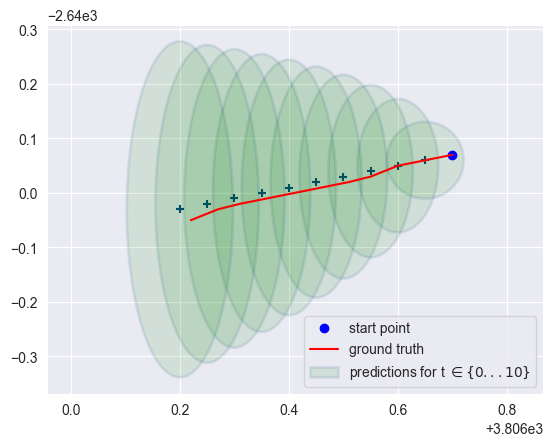

In [22]:
import numpy as np
from filterpy.stats import plot_covariance_ellipse

kPredictionHorizon = 10

x_0 = odometry_data.x_seq[0]
x_1 = odometry_data.x_seq[1]
vx = x_1 - x_0

y_0 = odometry_data.y_seq[0]
y_1 = odometry_data.y_seq[1]
vy = y_1 - y_0

pred_variance_x = 0.0005
pred_variance_y = 0.01
observe_std = 0.005

# the predict function that adds two gaussians
def predict(x, vx, y, vy, delta_t):
    y_pred = y + delta_t * vy # mean
    y_pred_std = observe_std + delta_t * pred_variance_y # variance

    x_pred = x + delta_t * vx
    x_pred_std = observe_std + delta_t * pred_variance_x

    return x_pred, y_pred, x_pred_std, y_pred_std


# plot start position
plt.plot(x_0, y_0, "bo")

for item in range(kPredictionHorizon):
    x_pred, y_pred, x_pred_var, y_pred_var = predict(x_1,vx,y_1,vy,item)

    covariance = np.array([[x_pred_var,          0    ],
                           [    0,          y_pred_var]])
    # plot covariances
    plot_covariance_ellipse((x_pred, y_pred), covariance, std=1, facecolor='g', alpha=0.1)

# plot ground truth
plt.plot(odometry_data.x_seq[0:kPredictionHorizon+1], odometry_data.y_seq[0:kPredictionHorizon+1], "r")

plt.legend(['start point', 'ground truth', 'predictions for t $\in \{0...10\}$']) 


The plot above outlines the inaccuracies of a constant velocity model for longer prediction horizons. Since we have defined a higher variance for the $y$ direction, we receive an ellipse for covariances of predictions $>t=1$.

**Key observation:  the ground truth and the predicted positions seem to be close to each other while the covariaces constantly increase. This is intuitively correct as we expect a constant velocity in our model (which is incorrect for longer horizons).**


We will see how this simple motion model is used in the (basic) Kalman Filter in the `02_kalman_filter` notebook.

# References


<a id="Thrun">[1]</a>: Thrun, Burgard, Fox, Probabilistic Robotics, MIT Press, 2006
